# X1 - Aggregate Population Dynamics

Exploration and classification of dynamical regimes wrt. weights of ecosystem and trade income

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns

setup

SETTING|VALUE
-|-
commit hash | [45aa5dd](https://github.com/fkuehlein/MayaSim/tree/45aa5dd85e16722cde5317d4735963cae09cbf9f)
jobid | 663753, 690515
parameter combinations | 36 x 36
samples | 32
tasks | 41472
samples per task | 4
ntasks (per array job) | 64
array-jobs | 162
computation time per job | h ~ ?  

total computation time ?

final clean run with fixes wrt. preliminary runs:
- no more double settlements ([f6d682c](https://github.com/fkuehlein/MayaSim/commit/f6d682cf9c920b31a8c45187c1907ab6394ee4d6))
- no more initial drought periods ([fa96093](https://github.com/fkuehlein/MayaSim/commit/fa96093a462c0103436d8a34022846d6c6e023e7))

In [17]:
# all parameter combinations
r_trades = np.arange(4000, 11200, 200).tolist()
r_ess = np.arange(0.005, 0.185, 0.005).round(decimals=3).tolist()

### single runs

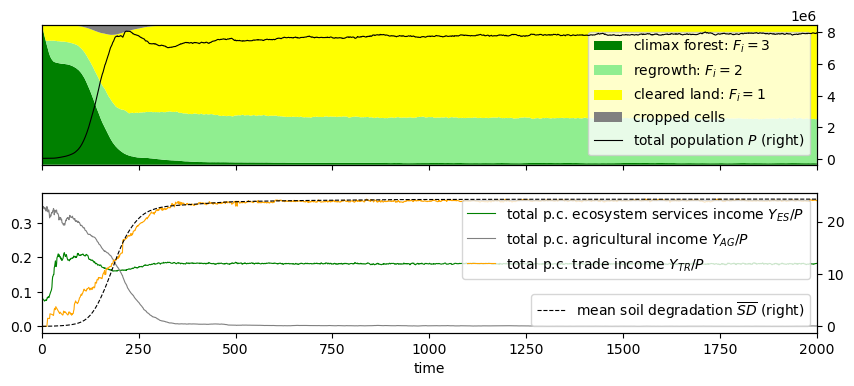

In [25]:
aggregate_run = pd.read_pickle('../output/X1_aggregate_dynamics/raw_data/9000-0o035-False_s25.pkl')['aggregates']

# plot aggregate trajectory
fig, axes = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)

# forest state
axes[0].stackplot(
    aggregate_run['time'],
    aggregate_run['forest_state_3_cells'],
    aggregate_run['forest_state_2_cells'],
    aggregate_run['forest_state_1_cells'] - aggregate_run['total_cropped_cells'],
    aggregate_run['total_cropped_cells'],
    colors=['green', 'lightgreen', 'yellow', 'grey'],
    labels=('climax forest: $F_i = 3$', 'regrowth: $F_i = 2$', 'cleared land: $F_i = 1$', 'cropped cells')
)

axes[0].set_ylim((0,101100))
axes[0].legend()

# population
secax = aggregate_run.plot('time', y='total_population', label='total population $P$', color='k', lw=.8, ax=axes[0], secondary_y=True)

# income per capita
es_income_pc = aggregate_run['total_income_ecosystem']/aggregate_run['total_population']
es_income_pc.plot(label='total p.c. ecosystem services income $Y_{ES}/P$', lw=.8, color='green', ax=axes[1])
ag_income_pc = aggregate_run['total_income_agriculture']/aggregate_run['total_population']
ag_income_pc.plot(label='total p.c. agricultural income $Y_{AG}/P$', lw=.8, color='grey', ax=axes[1])
tr_income_pc = aggregate_run['total_income_trade']/aggregate_run['total_population']
tr_income_pc.plot(label='total p.c. trade income $Y_{TR}/P$', lw=.8, color='orange', ax=axes[1])

# total income
#ax_2_1 = aggregate_run.plot('time', y='total_income_ecosystem', label='total ecosystem services income $Y_{ES}$', lw=.8, color='green', ax=axes[1])
#ax_2_2 = aggregate_run.plot('time', y='total_income_agriculture', label='total agricultural income $Y_{AG}$', lw=.8, color='grey', ax=axes[1])
#ax_2_3 = aggregate_run.plot('time', y='total_income_trade', label='total trade income $Y_{TR}$', lw=.8, color='orange', ax=axes[1])

# soil degradation
secax_2 = aggregate_run.plot('time', y='mean_soil_degradation', label='mean soil degradation $\overline{SD}$', ls='--', lw=.8, color='k', ax=axes[1], secondary_y=True)
secax_2.set_xlim((0, 2000))

axes[1].legend(loc='upper right')
secax_2.legend(loc='lower right')

### ensemble means

_re-run with 'mean' mode including `forest_state_2_cells` and `forest_state_1_cells`?_

In [2]:
ensemble_means = pd.read_pickle('../output/X1_aggregate_dynamics/results/ensemble_means.pkl')

ensemble_means = ensemble_means.droplevel('test')

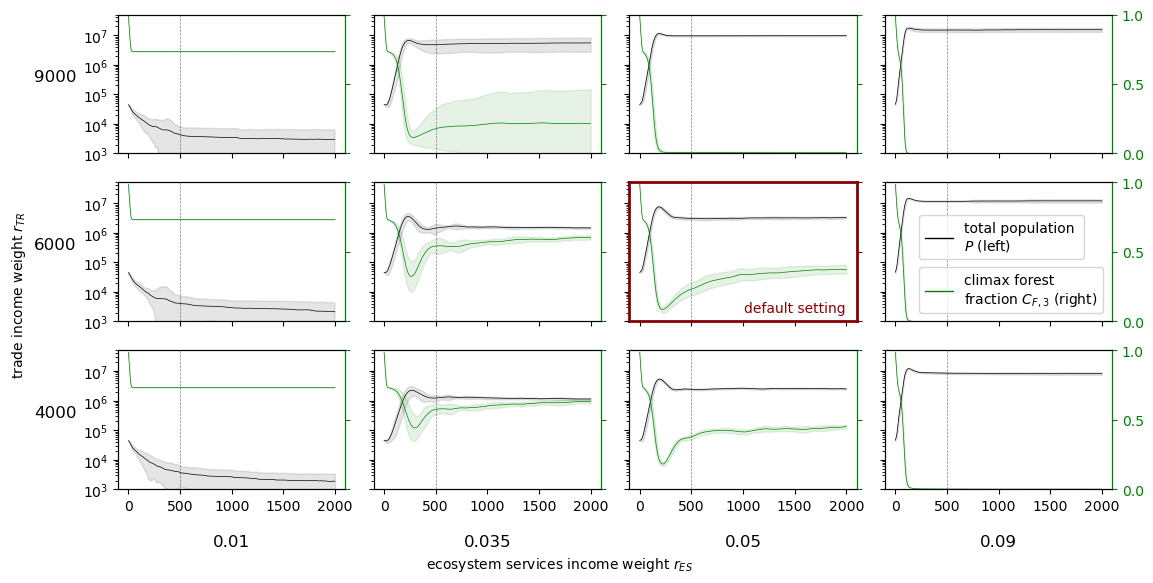

In [15]:
r_trades = [9000, 6000, 4000]
r_ess = [0.01, 0.035, 0.05, 0.09]

fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess), sharex=True, sharey=True)
fig.set_figwidth(3*len(r_ess))
fig.set_figheight(2*len(r_trades))

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    # plot mean
    pop_mean = ensemble_means.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_mean>']
    pop_mean.plot(ax=ax[j,i], color='k', lw=.5)

    # plot sigma
    pop_sigma = ensemble_means.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_sigma>']
    ax[j,i].fill_between(pop_mean.index, pop_mean + pop_sigma, pop_mean - pop_sigma, color='k', alpha=.1)

    # plot climax forest fraction
    climax_forest_mean = ensemble_means.loc[(r_trade, r_es)].xs('forest_state_3_cells', level=1)['<ensemble_mean>']/101100
    secax = (climax_forest_mean).plot(ax=ax[j,i], color='green', lw=.5, secondary_y=True, ylim=(0,1), yticks=(0,.5,1))
    # plot climax forest fraction sigma
    climax_forest_sigma = ensemble_means.loc[(r_trade, r_es)].xs('forest_state_3_cells', level=1)['<ensemble_sigma>']/101100
    secax.fill_between(climax_forest_sigma.index, climax_forest_mean + climax_forest_sigma, climax_forest_mean - climax_forest_sigma, color='green', alpha=.1)

    secax.tick_params(colors='green')
    secax.spines['right'].set_color('green')

    # mark spinup range
    ax[j,i].axvline(500, ls='--', c='k', lw=.5, alpha=.5)

    # outer ticks
    if i == 0:
        ax[j, i].set_ylabel(r_trade, rotation=0, size='large', labelpad=20)
        ax[j, i].yaxis.set_label_position("left")
    
    if not i == len(r_ess)-1:
        secax.set_yticklabels([])

    if j == len(r_trades)-1:
        ax[j, i].set_xlabel(r_es, size='large', labelpad=15)
        ax[j, i].xaxis.set_label_position("bottom")
    else:
        ax[j, i].set_xlabel(None)

    # ax[j,i].set_xlim(0, 2000)
    ax[j, i].set_ylim(1e3, 5e7)
    ax[j, i].set_yscale('log')

    # mark default parameter setting
    if r_trade == 6000 and r_es == 0.05:
        secax.tick_params(color='#8b0000')
        for spine in secax.spines.values():
            spine.set_edgecolor('#8b0000')
            spine.set_linewidth(2)
        ax[j,i].text(.95, .05, 'default setting', ha='right', va='bottom', c='#8b0000', transform=ax[j,i].transAxes)

    # place legend
    if i == len(r_ess)-1 and j == 1:
        secax_leg = secax.legend(['climax forest \nfraction $C_{F,3}$ (right)'], loc='lower left', bbox_to_anchor=(.12, .01))
        secax_leg.get_lines()[0].set_linewidth(1)
        ax_leg = ax[j,i].legend(['total population \n$P$ (left)'], loc='lower left', bbox_to_anchor=(.12, .4))
        ax_leg.get_lines()[0].set_linewidth(1)

# Set the overall grid titles for the x and y axes
fig.text(0.5, 0.05, 'ecosystem services income weight $r_{ES}$', ha='center', va='center')
fig.text(0.05, 0.5, 'trade income weight $r_{TR}$', ha='center', va='center', rotation='vertical')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

### ensemble-time mean population

NOTE: I calculate the error of the mean by square-adding sigma values. This assumes independence of values, which is certainly not the case for my timeseries. The statistically clean way would be to first do least-square fits of single model runs and then square-add residual-sums of each fit. However, that would require much more computational resources. The calculation shown here should still be a good first estimate.

In [8]:
# all parameter combinations
r_trades = np.arange(4000, 11200, 200).tolist()
r_ess = np.arange(0.005, 0.185, 0.005).round(decimals=3).tolist()

In [9]:
ensemble_means = pd.read_pickle('../output/X1_aggregate_dynamics/results/ensemble_means.pkl')

ensemble_means = ensemble_means.droplevel('test')

In [10]:
pop_mean = np.empty((len(r_ess), len(r_trades)))
pop_sig = np.empty((len(r_ess), len(r_trades)))

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    pop_mean[j,i] = ensemble_means.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_mean>'][500:].mean()

    sig = ensemble_means.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_sigma>'][500:].to_numpy()
    pop_sig[j,i] = np.sqrt(np.sum(sig**2))/len(sig)

    #pop_sig[j,i] = ensemble_means.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_sigma>'][500:].mean()

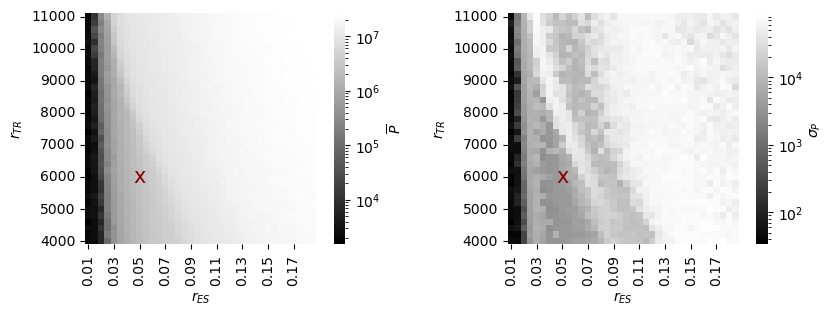

In [11]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

#cmap = plt.get_cmap('binary_r', 5)

sns.heatmap(pop_mean, ax=ax[0], square=True, cmap='binary_r', norm=LogNorm())
ax[0].collections[0].colorbar.set_label('$\overline{P}$')

sns.heatmap(pop_sig, ax=ax[1], square=True, cmap='binary_r', norm=LogNorm())
ax[1].collections[0].colorbar.set_label('$\sigma_P$')

for i in range(len(ax)):
    ax[i].invert_yaxis()
    ax[i].set_ylabel('$r_{TR}$')
    ax[i].set_xlabel('$r_{ES}$')
    ax[i].set_xticks(np.arange(.5, len(r_ess)+.5, 4), labels=r_ess[1::4], rotation=90)
    ax[i].set_yticks(np.arange(.5, len(r_trades)+.5, 5), labels=r_trades[::5], rotation=0)
    # mark default setting
    ax[i].text(8.5, 10.5, 'x', ha='center', va='center', c='#8b0000', size=15)
    #ax[i].text(10.5, 10.5, 'default \nsetting', ha='left', va='center', c='#8b0000', size=10)

### ensemble-time mean climax forest

In [12]:
for_mean = np.empty((len(r_ess), len(r_trades)))
for_sig = np.empty((len(r_ess), len(r_trades)))

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    for_mean[j,i] = ensemble_means.loc[(r_trade, r_es)].xs('forest_state_3_cells', level=1)['<ensemble_mean>'][500:].mean()

    sig = ensemble_means.loc[(r_trade, r_es)].xs('forest_state_3_cells', level=1)['<ensemble_sigma>'][500:].to_numpy()
    for_sig[j,i] = np.sqrt(np.sum(sig**2))/len(sig)

    #pop_sig[j,i] = ensemble_means.loc[(r_trade, r_es)].xs('total_population', level=1)['<ensemble_sigma>'][500:].mean()

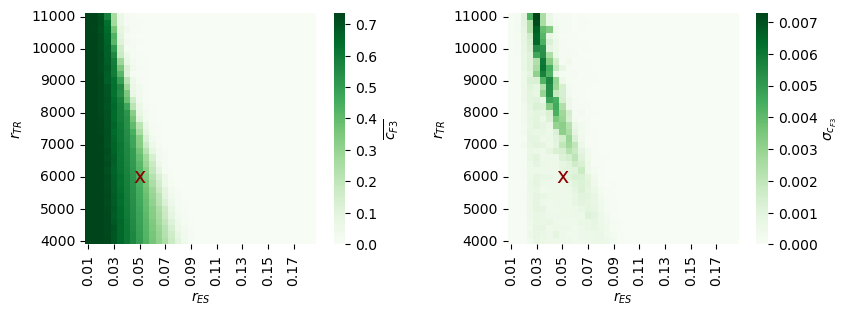

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

sns.heatmap(for_mean/101100, ax=ax[0], square=True, cmap='Greens')
ax[0].collections[0].colorbar.set_label('$\overline{c_{F3}}$')

#ax[1].set_title('SIGMA climax forest fraction')
sns.heatmap(for_sig/101100, ax=ax[1], square=True, cmap='Greens')
ax[1].collections[0].colorbar.set_label('$\sigma_{c_{F3}}$')

for i in range(len(ax)):
    ax[i].invert_yaxis()
    ax[i].set_ylabel('$r_{TR}$')
    ax[i].set_xlabel('$r_{ES}$')
    ax[i].set_xticks(np.arange(.5, len(r_ess)+.5, 4), labels=r_ess[1::4], rotation=90)
    ax[i].set_yticks(np.arange(.5, len(r_trades)+.5, 5), labels=r_trades[::5], rotation=0)
    # mark default setting
    ax[i].text(8.5, 10.5, 'x', ha='center', va='center', c='#8b0000', size=15)
    #ax[i].text(10.5, 10.5, 'default \nsetting', ha='left', va='center', c='#8b0000', size=10)

### all aggregate trajectories

In [9]:
# select parameters to plot
r_trades = [9000, 6000, 4000]
r_ess = [0.01, 0.035, 0.05, 0.09]

# load data
path = '../output/X1_aggregate_dynamics/results/all_trjs.hd5'
# path = '/p/tmp/fritzku/MayaSim/output/X1_aggregate_dynamics/results/all_trjs.hd5'

with pd.HDFStore(path) as store:
    df = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess}', columns=['total_population'])
    df = df.droplevel('test')

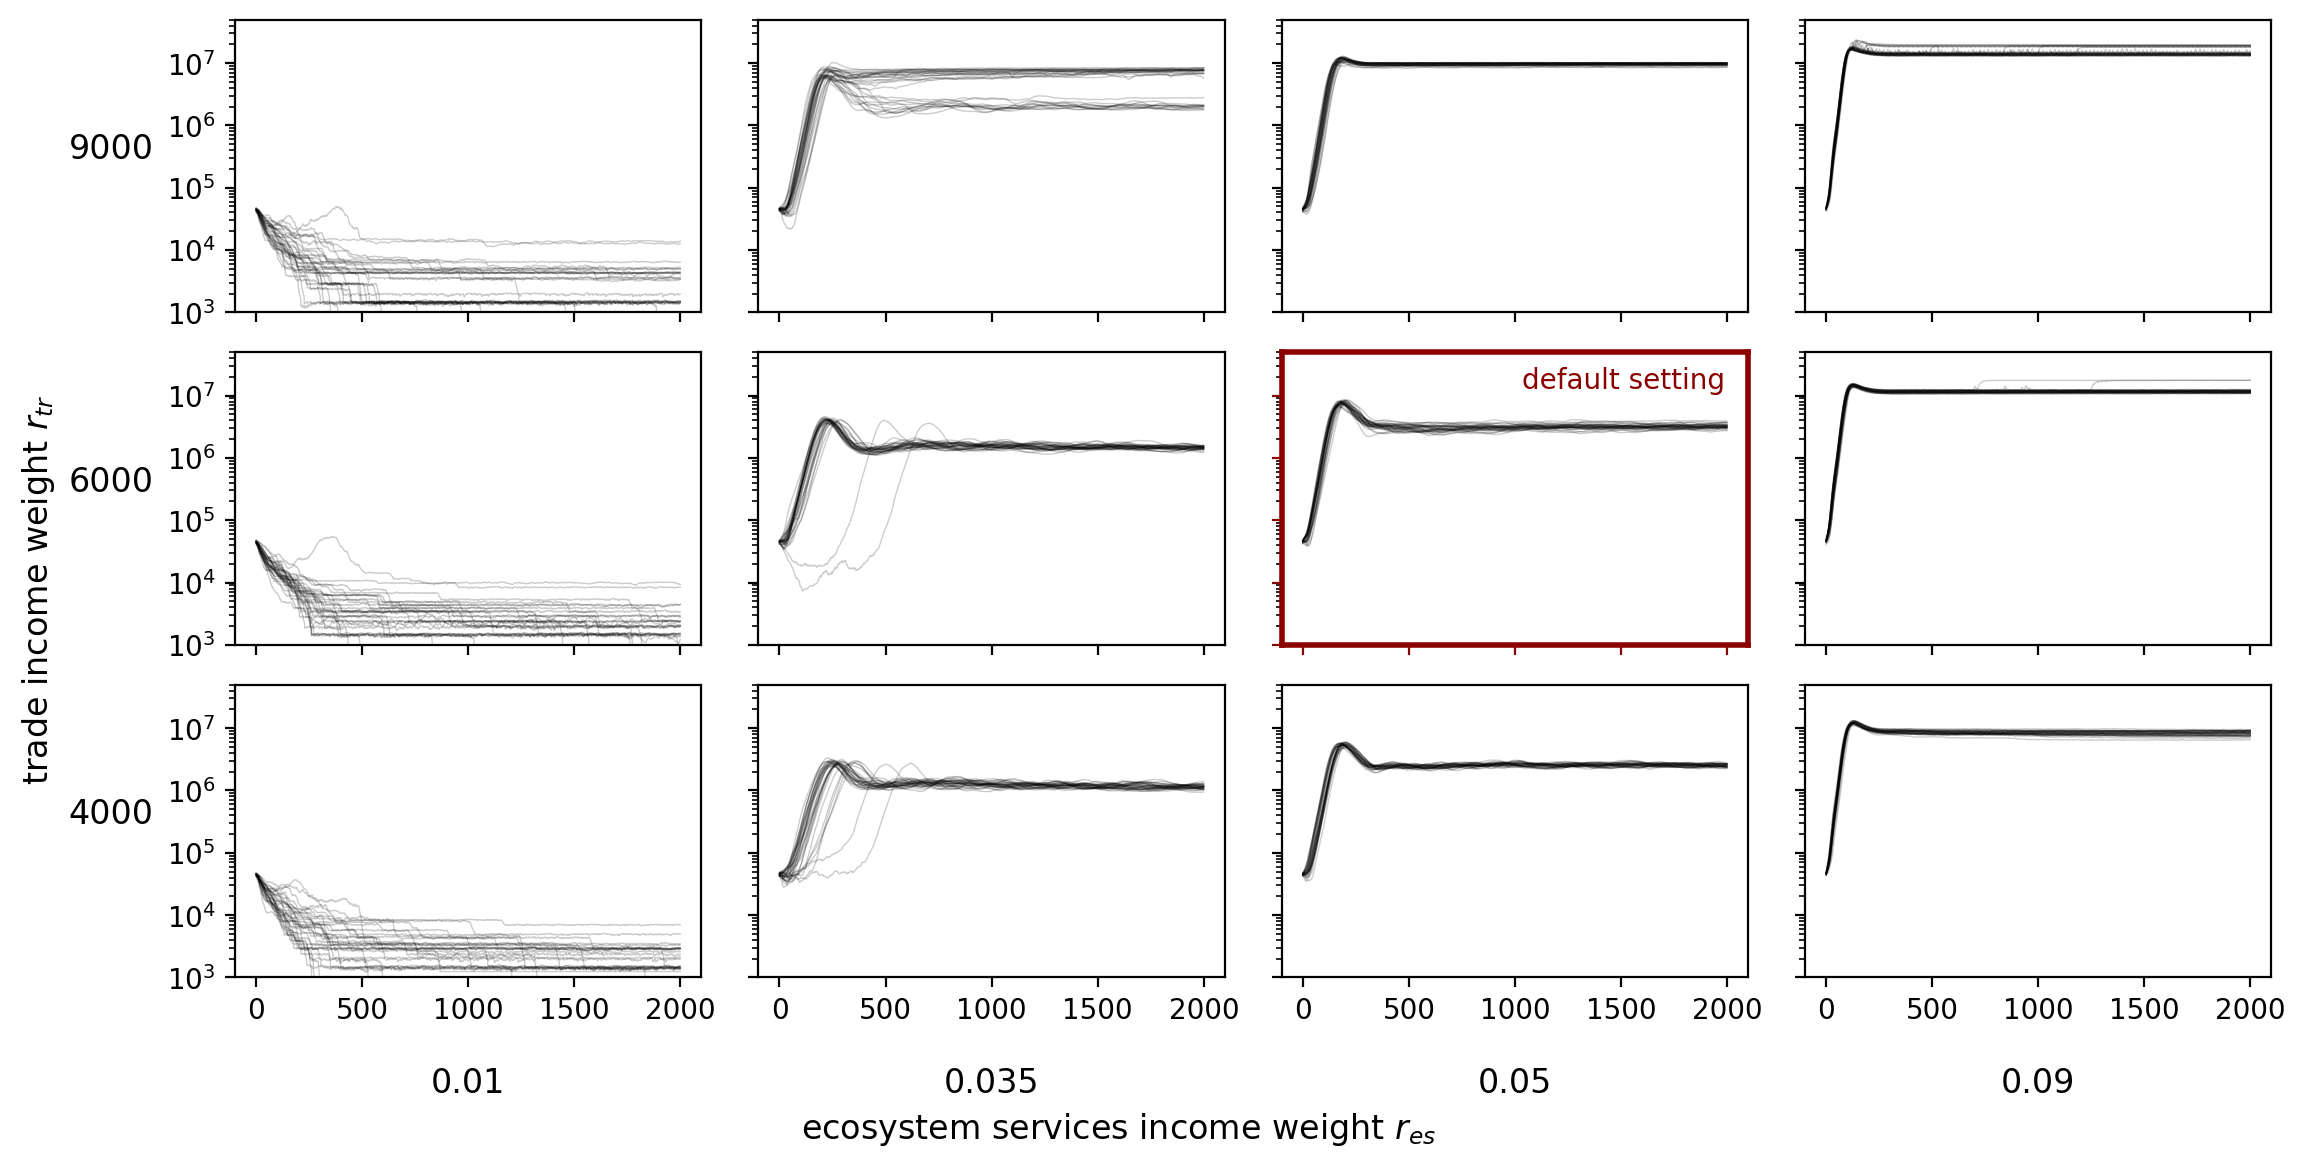

In [10]:
fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess), sharex=True, sharey=True)
fig.set_figwidth(3*len(r_ess))
fig.set_figheight(2*len(r_trades))
fig.set_dpi(200)

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    # plot population
    df.loc[(r_trade, r_es)].unstack('run_id').plot(y='total_population', ax=ax[j,i], legend=False, lw=.5, c='black', alpha=.2)

    # outer ticks
    if i == 0:
        ax[j, i].set_ylabel(r_trade, rotation=0, size='large', labelpad=20)
        ax[j, i].yaxis.set_label_position("left")

    if j == len(r_trades)-1:
        ax[j, i].set_xlabel(r_es, size='large', labelpad=15)
        ax[j, i].xaxis.set_label_position("bottom")
    else:
        ax[j,i].set_xlabel(None)

    #ax[j,i].set_ylim(-.1e7, 2.5e7)
    ax[j,i].set_ylim(1e3, 5e7)
    ax[j,i].set_yscale('log')

    # mark default parameter setting
    if r_trade == 6000 and r_es == 0.05:
        ax[j,i].tick_params(color='#8b0000')
        for spine in ax[j,i].spines.values():
            spine.set_edgecolor('#8b0000')
            spine.set_linewidth(2)
        ax[j,i].text(.95, .95, 'default setting', ha='right', va='top', c='#8b0000', transform=ax[j,i].transAxes)
        #ax[j,i].text(.95, .05, 'default setting', ha='right', va='bottom', c='#8b0000', transform=ax[j,i].transAxes)

# Set the overall grid titles for the x and y axes
fig.text(0.5, 0.05, 'ecosystem services income weight $r_{es}$', size='large', ha='center', va='center')
fig.text(0.05, 0.5, 'trade income weight $r_{tr}$', size='large', ha='center', va='center', rotation='vertical')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

### permutation entropy

for comparison to Jakob Kolb's results.

*NOTE: permutation entropy is not as helpful a measure to distinguish dynamical regimes with the revised model implementation*

too large to select full file, need to specify subset

In [174]:
r_trades = np.arange(4000, 11200, 200).tolist()
# r_ess = np.arange(0.005, 0.185, 0.005).round(decimals=3).tolist()
r_ess = np.arange(0.01, 0.185, 0.01).round(decimals=3).tolist()

# load data
path = '../output/X1_aggregate_dynamics/results/all_trjs.hd5'
# path = '/p/tmp/fritzku/MayaSim/output/X1_aggregate_dynamics/results/all_trjs.hd5'

with pd.HDFStore(path) as store:
    data = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess} & step>500', columns=['total_population'])
data.index = data.index.droplevel('test')

In [175]:
# generate empty dataframe with same index (minus 'steps')
index = data.index
entropy = pd.DataFrame(index=index, columns=['e'], dtype='float').groupby(level=(0,1,2)).sum()

In [176]:
# calculate permutation entropy for trajectories for t>500 (after initial overshoot)
from pyunicorn.timeseries import RecurrencePlot

for ind, row in entropy.iterrows():
    # load time series
    dft = data.loc[ind]
    # calculate permutation entropy
    e = RecurrencePlot(dft.values[:,0], dim=3, tau=1, skip_recurrence=True).permutation_entropy()
    # and save.
    entropy.loc[ind, 'e'] = e


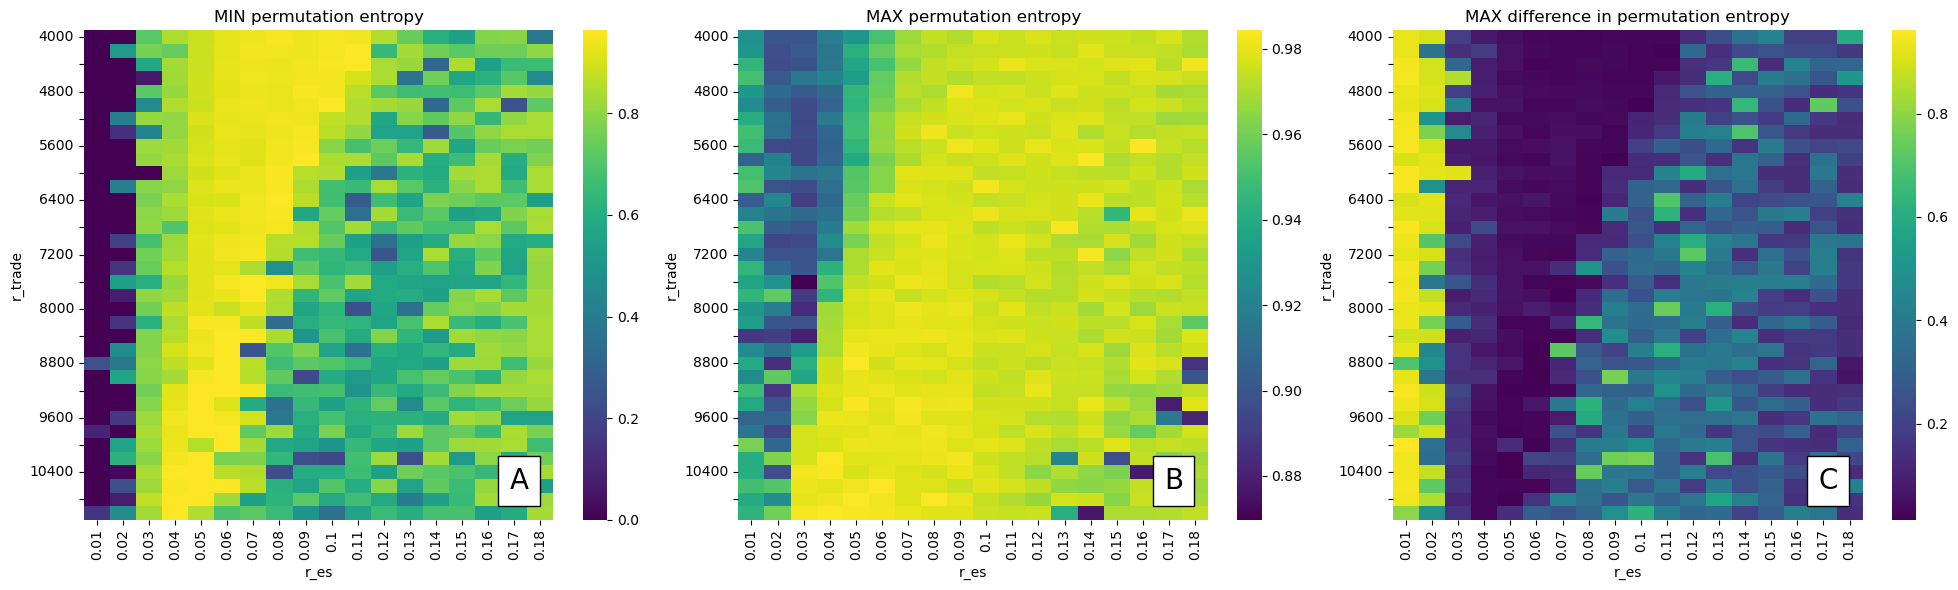

In [209]:
# plot heatmaps of permutation entropy for different values of r_es and r_trade

# create annotations
ann = pd.DataFrame(index=entropy.index, columns=['ann'], data=' ').groupby(level=(0, 1)).sum()

fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(20)
fig.set_figheight(6)

results = entropy.groupby(level=[0,1]).min()
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[0])
ax[0].set_title('MIN permutation entropy')

# results = entropy.groupby(level=[0,1]).mean()
# sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[1])
# ax[1].set_title('MEAN permutation entropy')

results = entropy.groupby(level=[0,1]).max()
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[1])
ax[1].set_title('MAX permutation entropy')

results = entropy.groupby(level=[0,1]).max() - entropy.groupby(level=[0,1]).min()
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[2])
ax[2].set_title('MAX difference in permutation entropy')

def add_at(ax, t, loc=2):
    from matplotlib.offsetbox import AnchoredText
    fp = dict(size=20)
    _at = AnchoredText(t, loc=loc, prop=fp)
    ax.add_artist(_at)
    return _at

for x, no in zip(ax, ['A', 'B', 'C']):
    add_at(x, no, loc=4)
    for label in x.get_yaxis().get_ticklabels()[1::2]:
        label.set_visible(False)

fig.set_tight_layout(True)
#fig.savefig('permutation_entropy.pdf')
#fig.savefig('permutation_entropy.png')

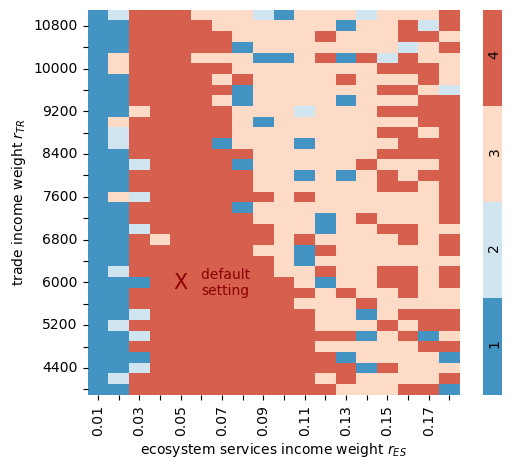

In [210]:
mins = entropy.groupby(level=[0,1]).min()


classification = pd.DataFrame(columns = ['min'], index=mins.index, data=mins.values)
classification['max'] = entropy['e'].groupby(level=[0,1]).max()
classification['dif'] = classification['max'] - classification['min']

classification['cls'] = float('nan')

classification.loc[classification['min']>.7, 'cls'] = 4
classification.loc[classification['min']<.7, 'cls'] = 2
classification.loc[classification['dif']>.5, 'cls'] = 1
classification.loc[[(.19<x<.5) & (y>.5) & (z>.9) for x, y, z in zip(classification['dif'], classification['min'], classification['max'])], 'cls'] = 3
# classification.loc[[(x>.4) & (y<.77) for x, y in zip(classification['min'], classification['max'])], 'cls'] = 2

fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(5)
cmap = sns.color_palette("RdBu_r", 4)

sns.heatmap(classification['cls'].unstack('r_es'), ax=ax, cmap=cmap)

# use every second x and y tick label
for label in ax.get_xaxis().get_ticklabels()[1::2]:
    label.set_visible(False)

for label in ax.get_yaxis().get_ticklabels()[::2]:
    label.set_visible(False)

# invert y axis
ax.invert_yaxis()
ax.set_xlabel('ecosystem services income weight $r_{ES}$')
ax.set_ylabel('trade income weight $r_{TR}$')

# mark default setting
ax.text(4.5, 10.5, 'x', ha='center', va='center', c='#8b0000', size=15)
ax.text(5.5, 10.5, 'default \nsetting', ha='left', va='center', c='#8b0000', size=10)

# adjust color bar
cax = plt.gcf().axes[-1]
cax.get_yaxis().set_ticks([])
for j, lab in enumerate(['1','2','3', '4']):
    cax.text(.6, (0.75 * j + 1.4), lab, ha='center', va='center', rotation=90)

# fig.savefig('classified_dynamics.pdf')

### colored lines

In [211]:
import matplotlib
import matplotlib.cm as cm

norm = matplotlib.colors.Normalize(vmin=0., vmax=1., clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

In [212]:
# select parameters to plot
r_trades = [9000, 6000, 4000]
r_ess = [0.01, 0.035, 0.05, 0.09]

# load data
path = '../output/X1_aggregate_dynamics/results/all_trjs.hd5'
# path = '/p/tmp/fritzku/MayaSim/output/X1_aggregate_dynamics/results/all_trjs.hd5'

with pd.HDFStore(path) as store:
    df = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess}', columns=['total_population'])
    df = df.droplevel('test')

In [213]:
with pd.HDFStore(path) as store:
    data = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess} & step>500', columns=['total_population'])
data.index = data.index.droplevel('test')

# generate empty dataframe with same index (minus 'steps')
index = data.index
entropy = pd.DataFrame(index=index, columns=['e'], dtype='float').groupby(level=(0,1,2)).sum()

In [214]:
# calculate permutation entropy for trajectories for t>500 (after initial overshoot)
from pyunicorn.timeseries import RecurrencePlot

for ind, row in entropy.iterrows():
    # load time series
    dft = data.loc[ind]
    # calculate permutation entropy
    e = RecurrencePlot(dft.values[:,0], dim=3, tau=1, skip_recurrence=True).permutation_entropy()
    # and save.
    entropy.loc[ind, 'e'] = e


/var/folders/8j/pr33ty9n1wz1gnjmz1v7khzm0000gn/T/ipykernel_19781/3764369883.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 1])


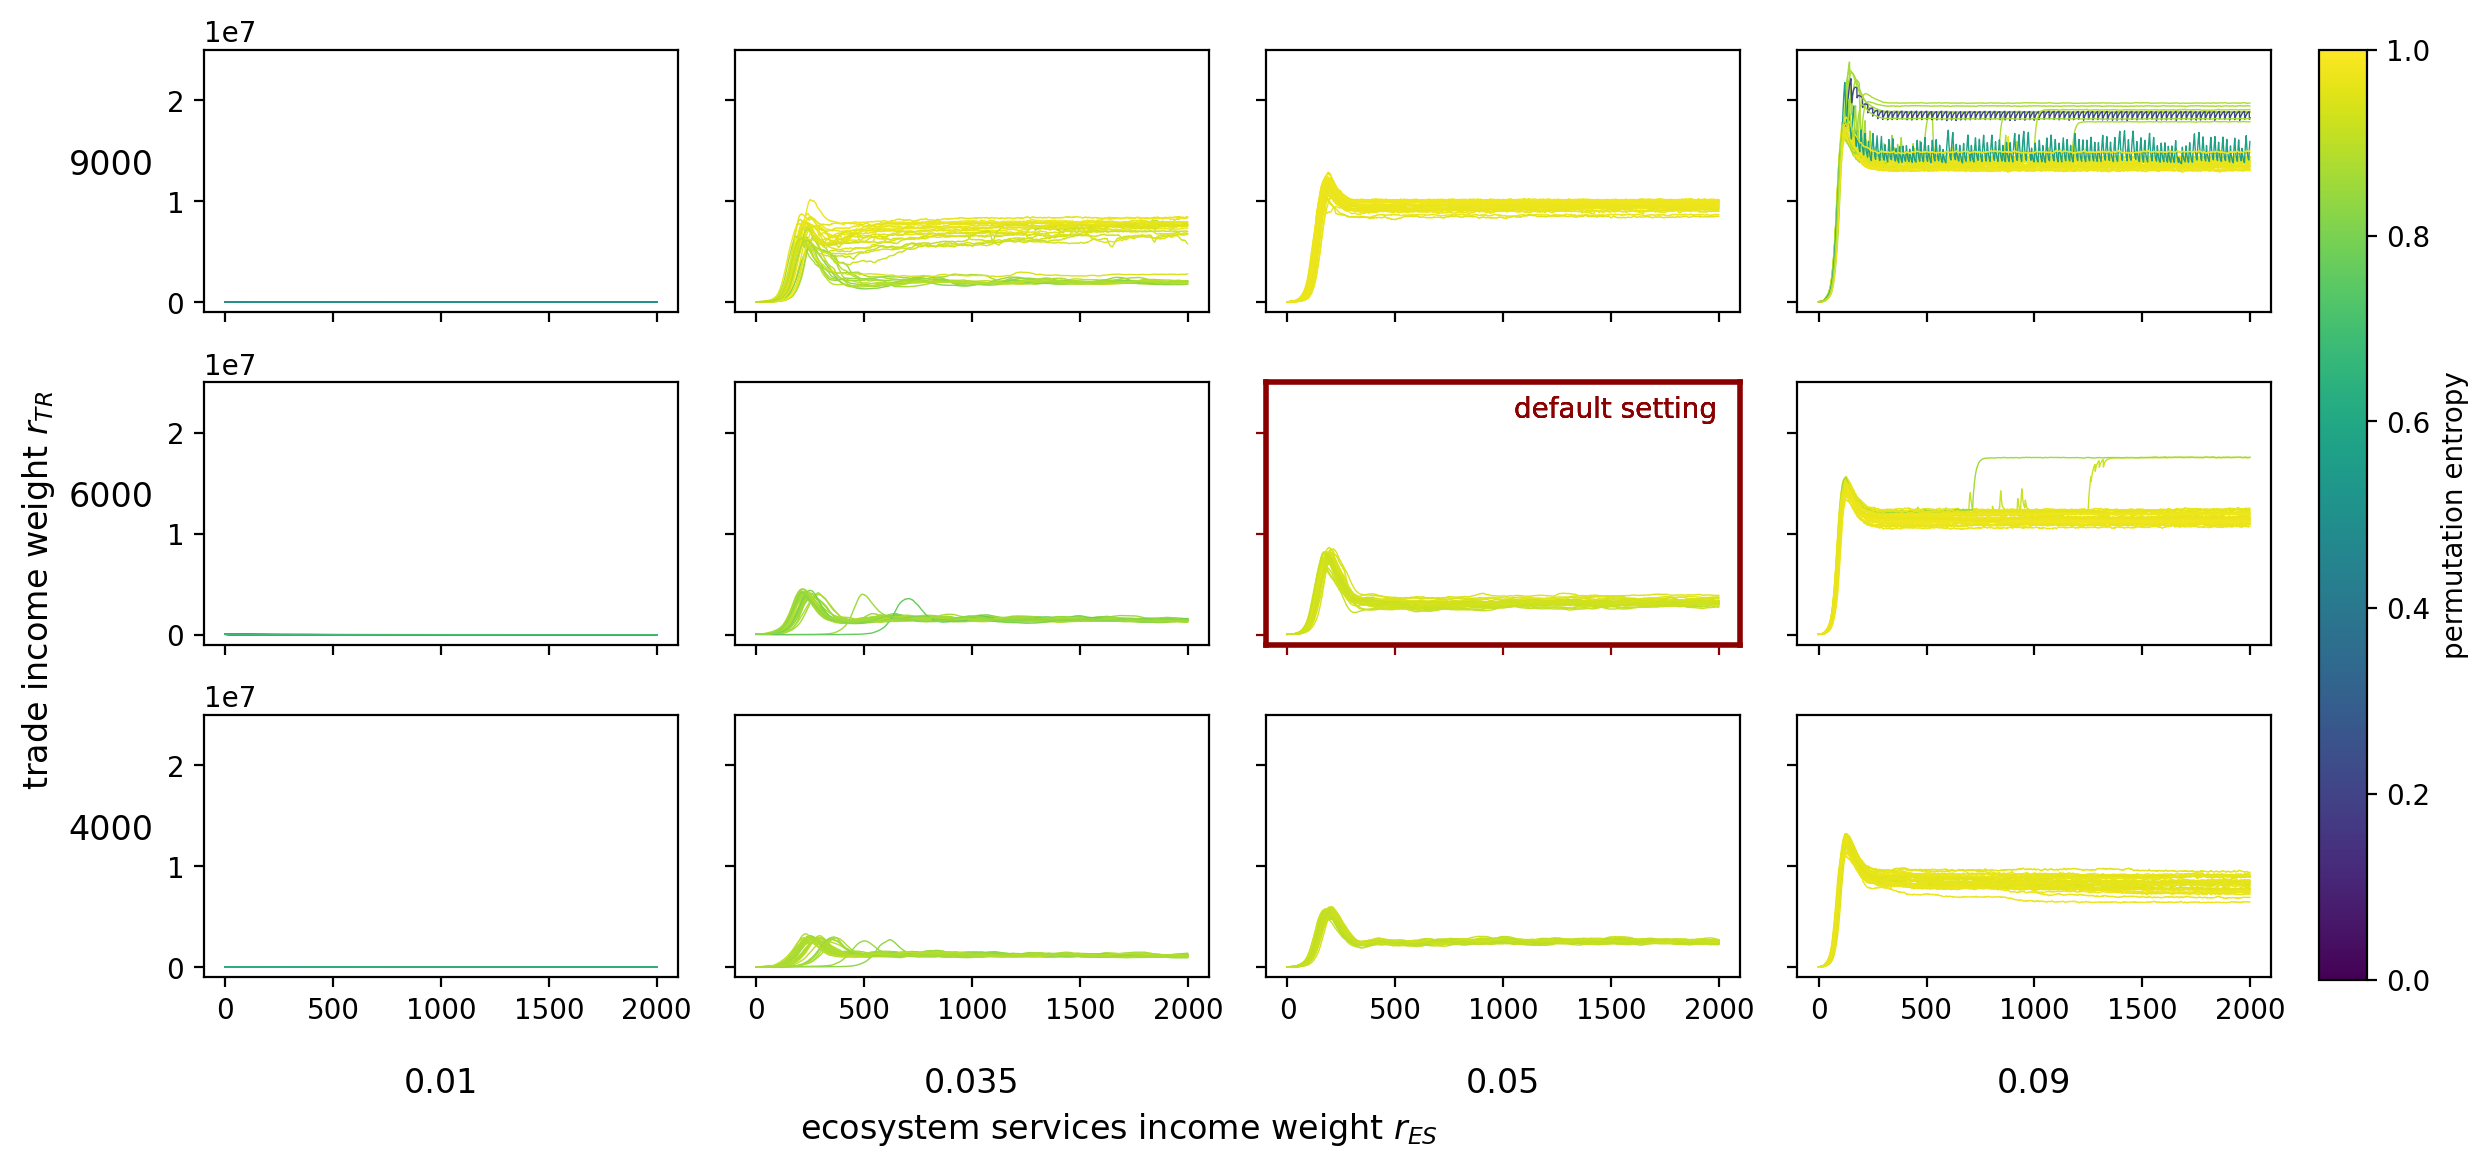

In [215]:
fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess), sharex=True, sharey=True)
fig.set_figwidth(3*len(r_ess))
fig.set_figheight(2*len(r_trades))
fig.set_dpi(200)

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    run_ids = df.index.levels[2]
    col = entropy.loc[(r_trade, r_es)].unstack('run_id')
    pop = df.loc[(r_trade, r_es)].unstack('run_id')
    pop.columns = pop.columns.droplevel(0)
    # plot population
    for run_id in run_ids:
        color = mapper.to_rgba(col.iloc[run_id])
        ln = pop[[run_id]].plot(ax=ax[j,i], color=color, legend=False, lw=.5)

    # outer ticks
    if i == 0:
        ax[j, i].set_ylabel(r_trade, rotation=0, size='large', labelpad=20)
        ax[j, i].yaxis.set_label_position("left")

    if j == len(r_trades)-1:
        ax[j, i].set_xlabel(r_es, size='large', labelpad=15)
        ax[j, i].xaxis.set_label_position("bottom")
    else:
        ax[j,i].set_xlabel(None)

    ax[j,i].set_ylim(-.1e7, 2.5e7)

    # mark default parameter setting
    if r_trade == 6000 and r_es == 0.05:
        ax[j,i].tick_params(color='#8b0000')
        for spine in ax[j,i].spines.values():
            spine.set_edgecolor('#8b0000')
            spine.set_linewidth(2)
            ax[j,i].text(.95, .95, 'default setting', ha='right', va='top', c='#8b0000', transform=ax[j,i].transAxes)

# Set the overall grid titles for the x and y axes
fig.text(0.5, 0.05, 'ecosystem services income weight $r_{ES}$', size='large', ha='center', va='center')
fig.text(0.05, 0.5, 'trade income weight $r_{TR}$', size='large', ha='center', va='center', rotation='vertical')

# add colorbar
cax = plt.axes((1, 0.175, 0.02, 0.775))
fig.colorbar(mapper, cax=cax, label='permutation entropy')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

/var/folders/8j/pr33ty9n1wz1gnjmz1v7khzm0000gn/T/ipykernel_19781/2389905269.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 1])


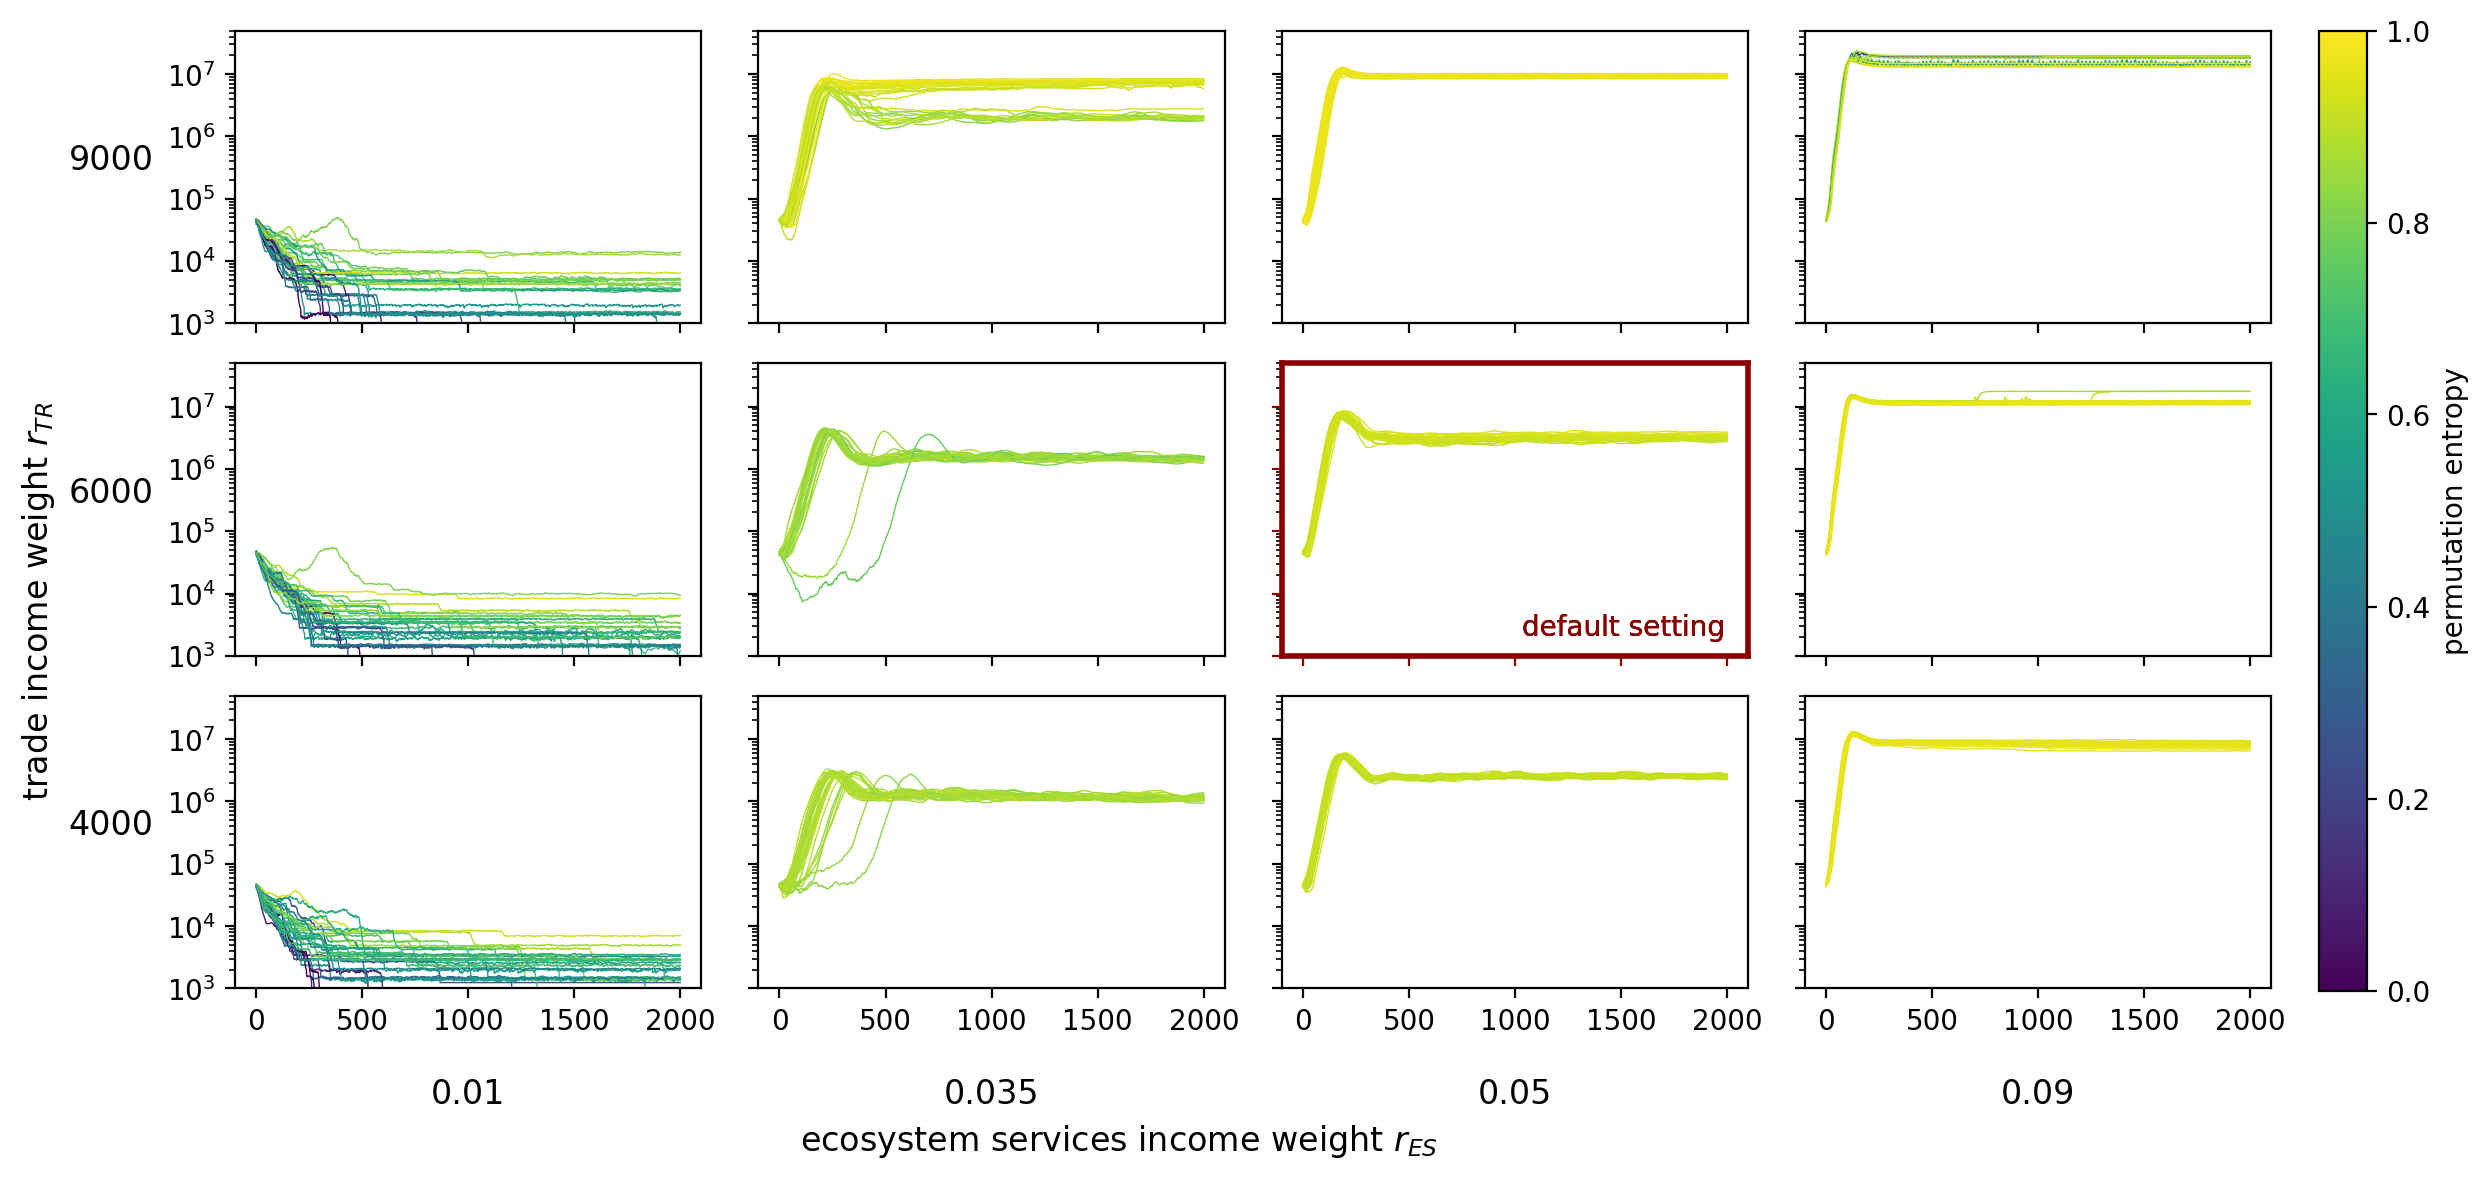

In [216]:
fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess), sharex=True, sharey=True)
fig.set_figwidth(3*len(r_ess))
fig.set_figheight(2*len(r_trades))
fig.set_dpi(200)

for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):
    run_ids = df.index.levels[2]
    col = entropy.loc[(r_trade, r_es)].unstack('run_id')
    pop = df.loc[(r_trade, r_es)].unstack('run_id')
    pop.columns = pop.columns.droplevel(0)
    # plot population
    for run_id in run_ids:
        color = mapper.to_rgba(col.iloc[run_id])
        ln = pop[[run_id]].plot(ax=ax[j,i], color=color, legend=False, lw=.5)

    # outer ticks
    if i == 0:
        ax[j, i].set_ylabel(r_trade, rotation=0, size='large', labelpad=20)
        ax[j, i].yaxis.set_label_position("left")

    if j == len(r_trades)-1:
        ax[j, i].set_xlabel(r_es, size='large', labelpad=15)
        ax[j, i].xaxis.set_label_position("bottom")
    else:
        ax[j,i].set_xlabel(None)

    ax[j,i].set_ylim(1e3, 5e7)
    ax[j,i].set_yscale('log')

    # mark default parameter setting
    if r_trade == 6000 and r_es == 0.05:
        ax[j,i].tick_params(color='#8b0000')
        for spine in ax[j,i].spines.values():
            spine.set_edgecolor('#8b0000')
            spine.set_linewidth(2)
            ax[j,i].text(.95, .05, 'default setting', ha='right', va='bottom', c='#8b0000', transform=ax[j,i].transAxes)

# Set the overall grid titles for the x and y axes
fig.text(0.5, 0.05, 'ecosystem services income weight $r_{ES}$', size='large', ha='center', va='center')
fig.text(0.05, 0.5, 'trade income weight $r_{TR}$', size='large', ha='center', va='center', rotation='vertical')

# add colorbar
cax = plt.axes((1, 0.175, 0.02, 0.8))
fig.colorbar(mapper, cax=cax, label='permutation entropy')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 1])